**Support Vector Machines**

_This notebook contains all the sample code and solutions to the exercises in chapter 5._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/05_support_vector_machines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/05_support_vector_machines.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [3]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [4]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [5]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/svm` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [6]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "svm"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

A support vector machine (SVM) is a powerful and versatile machine learning model,
capable of performing linear or nonlinear classification, regression, and even novelty
detection. SVMs shine with small to medium-sized nonlinear datasets (i.e., hundreds
to thousands of instances), especially for classification tasks. However, they don’t scale
very well to very large datasets, as you will see.

# Linear SVM Classification

The fundamental idea behind SVMs is best explained with some visuals:

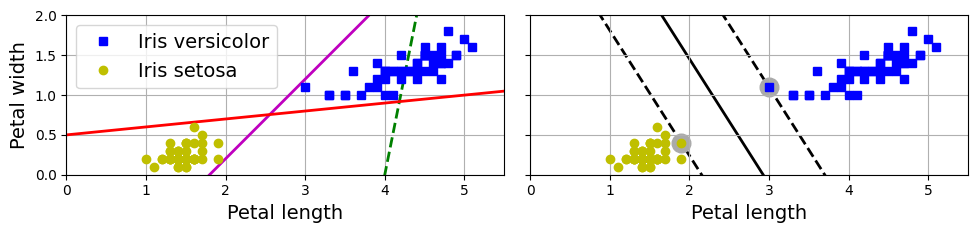

In [5]:
# extra code – this cell generates and saves Figure 5–1

import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM Classifier model
svm_clf = SVC(kernel="linear", C=1e100)
svm_clf.fit(X, y)

# Bad models
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5 * x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0] / w[1] * x0 - b / w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin
    svs = svm_clf.support_vectors_

    plt.plot(x0, decision_boundary, "k-", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_up, "k--", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_down, "k--", linewidth=2, zorder=-2)
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#AAA',
                zorder=-1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 2.7), sharey=True)

plt.sca(axes[0])
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.axis([0, 5.5, 0, 2])
plt.gca().set_aspect("equal")
plt.grid()

plt.sca(axes[1])
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length")
plt.axis([0, 5.5, 0, 2])
plt.gca().set_aspect("equal")
plt.grid()

save_fig("large_margin_classification_plot")
plt.show()

In the above figure, the two
classes can clearly be separated easily with a straight line (they are linearly separable).
The left plot shows the decision boundaries of three possible linear classifiers. The
model whose decision boundary is represented by the dashed line is so bad that it
does not even separate the classes properly. The other two models work perfectly
on this training set, but their decision boundaries come so close to the instances
that these models will probably not perform as well on new instances. In contrast,
the solid line in the plot on the right represents the decision boundary of an SVM
classifier; this line not only separates the two classes but also stays as far away from
the closest training instances as possible. You can think of an SVM classifier as
fitting the widest possible street (represented by the parallel dashed lines) between the
classes. This is called large margin classification.

Notice that adding more training instances “off the street” will not affect the decision
boundary at all: it is fully determined (or “supported”) by the instances located on the
edge of the street. These instances are called the support vectors (they are circled in the figure above)

**Sensitive to feature scacles**:

SVMs are sensitive to the feature scales, as you can see in Figure below. In the left plot, the vertical scale is much larger than the
horizontal scale, so the widest possible street is close to horizontal.
After feature scaling (e.g., using Scikit-Learn’s StandardScaler),
the decision boundary in the right plot looks much better.

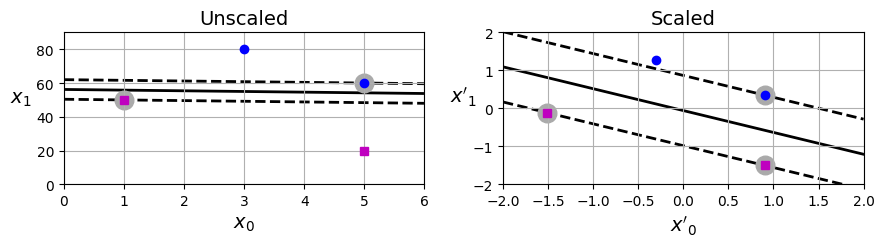

In [6]:
# extra code – this cell generates and saves Figure 5–2

from sklearn.preprocessing import StandardScaler

Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear", C=100).fit(Xs, ys)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf_scaled = SVC(kernel="linear", C=100).fit(X_scaled, ys)

plt.figure(figsize=(9, 2.7))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$")
plt.ylabel("$x_1$    ", rotation=0)
plt.title("Unscaled")
plt.axis([0, 6, 0, 90])
plt.grid()

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf_scaled, -2, 2)
plt.xlabel("$x'_0$")
plt.ylabel("$x'_1$  ", rotation=0)
plt.title("Scaled")
plt.axis([-2, 2, -2, 2])
plt.grid()

save_fig("sensitivity_to_feature_scales_plot")
plt.show()

## Soft Margin Classification

If we strictly impose that all instances must be off the street and on the correct
side, this is called **hard margin classification**. There are two main issues with hard
margin classification: 

First, it only works if the data is linearly separable.

Second, it is sensitive to outliers. Figure below shows the iris dataset with just one additional outlier:
on the left, it is impossible to find a hard margin; on the right, the decision boundary
ends up very different from the one we saw two figures above without the outlier, and the
model will probably not generalize as well.

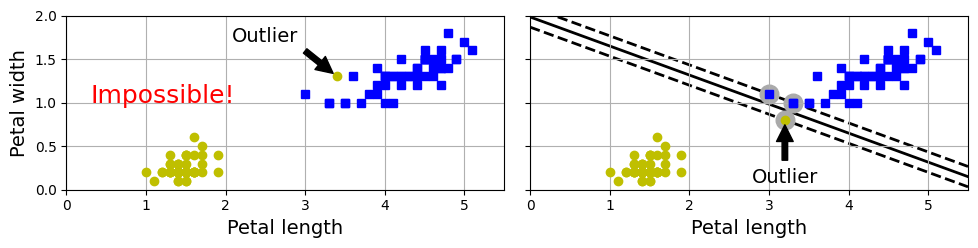

In [7]:
# extra code – this cell generates and saves Figure 5–3

X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

fig, axes = plt.subplots(ncols=2, figsize=(10, 2.7), sharey=True)

plt.sca(axes[0])
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Impossible!", color="red", fontsize=18)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.annotate(
    "Outlier",
    xy=(X_outliers[0][0], X_outliers[0][1]),
    xytext=(2.5, 1.7),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
)
plt.axis([0, 5.5, 0, 2])
plt.grid()

plt.sca(axes[1])
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length")
plt.annotate(
    "Outlier",
    xy=(X_outliers[1][0], X_outliers[1][1]),
    xytext=(3.2, 0.08),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
)
plt.axis([0, 5.5, 0, 2])
plt.grid()

save_fig("sensitivity_to_outliers_plot")
plt.show()

To avoid these issues, we need to use a more flexible model. The objective is to find a
good balance between keeping the street as large as possible and limiting the margin
violations (i.e., instances that end up in the middle of the street or even on the wrong
side). This is called **soft margin classification**.

Note: the default value for the `dual` hyperparameter of the `LinearSVC` and `LinearSVR` estimators will change from `True` to `"auto"` in Scikit-Learn 1.4, so I set `dual=True` throughout this notebook to ensure the output of this notebook remains unchanged.

The following Scikit-Learn code loads the iris dataset and trains a linear SVM classi‐
fier to detect Iris virginica flowers. The pipeline first scales the features, then uses a
LinearSVC with C=1:

In [8]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 2)  # Iris virginica

svm_clf = make_pipeline(StandardScaler(),
                        LinearSVC(C=1, dual=True, random_state=42))
svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(C=1, dual=True, random_state=42))])

The resulting model is represented on the left in Figure 5-4.

Then, as usual, you can use the model to make predictions:

In [9]:
X_new = [[5.5, 1.7], [5.0, 1.5]]
svm_clf.predict(X_new)

array([ True, False])

The first plant is classified as an Iris virginica, while the second is not. Let’s look at
the scores that the SVM used to make these predictions. These measure the signed
distance between each instance and the decision boundary:

In [10]:
svm_clf.decision_function(X_new)

array([ 0.66163411, -0.22036063])

The data classified as iris virginica is 0.66 unitis of distance above the decision boundary while the other is 0.22 below it

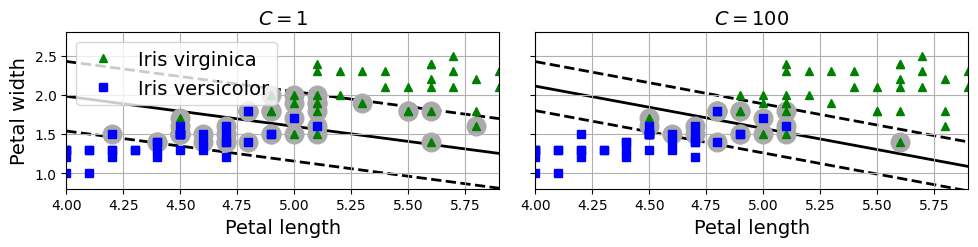

In [11]:
# extra code – this cell generates and saves Figure 5–4

from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline

scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, max_iter=10_000, dual=True, random_state=42)
svm_clf2 = LinearSVC(C=100, max_iter=10_000, dual=True, random_state=42)

scaled_svm_clf1 = make_pipeline(scaler, svm_clf1)
scaled_svm_clf2 = make_pipeline(scaler, svm_clf2)

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

# Convert to unscaled parameters
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Find support vectors (LinearSVC does not do this automatically)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

fig, axes = plt.subplots(ncols=2, figsize=(10, 2.7), sharey=True)

plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.title(f"$C = {svm_clf1.C}$")
plt.axis([4, 5.9, 0.8, 2.8])
plt.grid()

plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal length")
plt.title(f"$C = {svm_clf2.C}$")
plt.axis([4, 5.9, 0.8, 2.8])
plt.grid()

save_fig("regularization_plot")
plt.show()

When creating an SVM model using Scikit-Learn, you can specify several hyperpara‐
meters, including the regularization hyperparameter C. If you set it to a low value,
then you end up with the model on the left of figure above. With a high value, you get
the model on the right. As you can see, reducing C makes the street larger, but it also
leads to more margin violations. In other words, reducing C results in more instances
supporting the street, so there’s less risk of overfitting. But if you reduce it too much,
then the model ends up underfitting, as seems to be the case here: the model with
C=100 looks like it will generalize better than the one with C=1.

Unlike LogisticRegression, LinearSVC doesn’t have a predict_proba() method to
estimate the class probabilities. That said, if you use the SVC class (discussed shortly)
instead of LinearSVC, and if you set its probability hyperparameter to True, then
the model will fit an extra model at the end of training to map the SVM decision
function scores to estimated probabilities. Under the hood, this requires using 5-fold
cross-validation to generate out-of-sample predictions for every instance in the train‐
ing set, then training a LogisticRegression model, so it will slow down training
considerably. After that, the predict_proba() and predict_log_proba() methods
will be available.

# Nonlinear SVM Classification

Although linear SVM classifiers are efficient and often work surprisingly well, many
datasets are not even close to being linearly separable. One approach to handling
nonlinear datasets is to add more features, such as polynomial features (as we did in
Chapter 4); in some cases this can result in a linearly separable dataset. Consider the
lefthand plot in Figure below: it represents a simple dataset with just one feature, x1.
This dataset is not linearly separable, as you can see. But if you add a second feature
x2 = (x1)^2, the resulting 2D dataset is perfectly linearly separable.

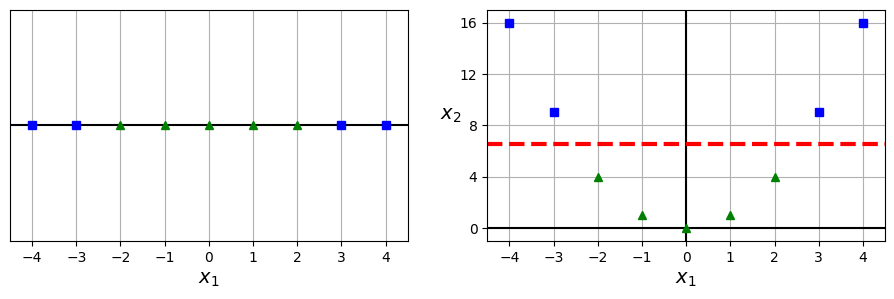

In [15]:
# extra code – this cell generates and saves Figure 5–5

X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10, 3))

plt.subplot(121)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel("$x_1$")
plt.axis([-4.5, 4.5, -0.2, 0.2])

plt.subplot(122)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$  ", rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
plt.axis([-4.5, 4.5, -1, 17])

plt.subplots_adjust(right=1)

save_fig("higher_dimensions_plot", tight_layout=False)
plt.show()

To implement this idea using Scikit-Learn, you can create a pipeline containing a
PolynomialFeatures transformer (discussed in “Polynomial Regression” on page
149), followed by a StandardScaler and a LinearSVC classifier. Let’s test this on the
moons dataset, a toy dataset for binary classification in which the data points are
shaped as two interleaving crescent moons (see Figure 5-6). You can generate this
dataset using the make_moons() function:

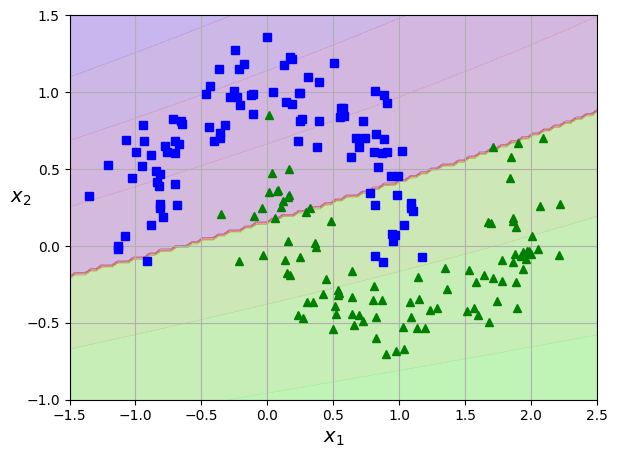

In [26]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=200, noise=0.15, random_state=42)

polynomial_svm_clf = make_pipeline(
    PolynomialFeatures(degree=2),
    StandardScaler(),
    LinearSVC(C=10, max_iter=10_000, dual=True, random_state=42)
)
polynomial_svm_clf.fit(X, y)

# extra code – this cell generates and saves Figure 5–6

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

save_fig("moons_polynomial_deg2_svc_plot")
plt.show()

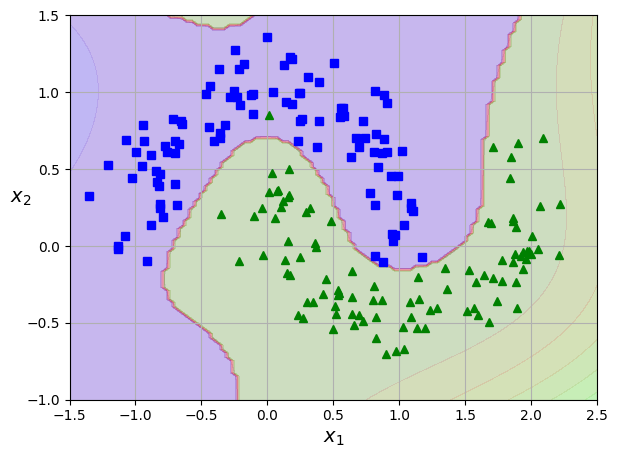

In [27]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=200, noise=0.15, random_state=42)

polynomial_svm_clf = make_pipeline(
    PolynomialFeatures(degree=4),
    StandardScaler(),
    LinearSVC(C=10, max_iter=10_000, dual=True, random_state=42)
)
polynomial_svm_clf.fit(X, y)

# extra code – this cell generates and saves Figure 5–6

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

save_fig("moons_polynomial_deg4_svc_plot")
plt.show()

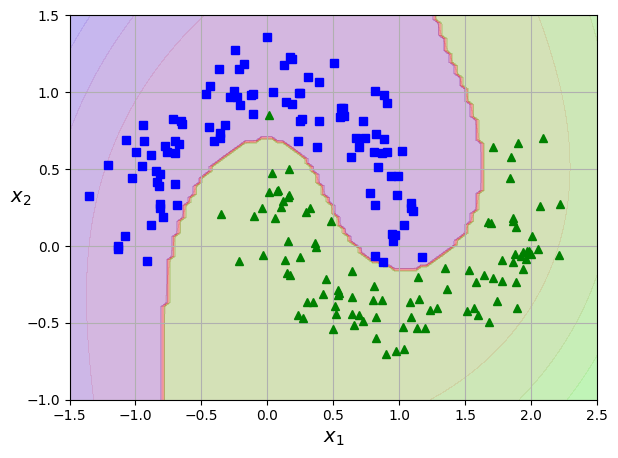

In [28]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=200, noise=0.15, random_state=42)

polynomial_svm_clf = make_pipeline(
    PolynomialFeatures(degree=3),
    StandardScaler(),
    LinearSVC(C=10, max_iter=10_000, dual=True, random_state=42)
)
polynomial_svm_clf.fit(X, y)

# extra code – this cell generates and saves Figure 5–6

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

save_fig("moons_polynomial_deg3_svc_plot")
plt.show()

## Polynomial Kernel

Adding polynomial features is simple to implement and can work great with all sorts
of machine learning algorithms (not just SVMs). That said, at a low polynomial
degree this method cannot deal with very complex datasets, and with a high polyno‐
mial degree it creates a huge number of features, making the model too slow.

Fortunately, when using SVMs you can apply an almost miraculous mathematical
technique called the kernel trick (which is explained later in this chapter). The kernel
trick makes it possible to get the same result as if you had added many polynomial
features, even with a very high degree, without actually having to add them. This
means there’s no combinatorial explosion of the number of features. This trick is
implemented by the SVC class. Let’s test it on the moons dataset:

In [29]:
from sklearn.svm import SVC

poly_kernel_svm_clf = make_pipeline(StandardScaler(),
                                    SVC(kernel="poly", degree=3, coef0=1, C=5))
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=5, coef0=1, kernel='poly'))])

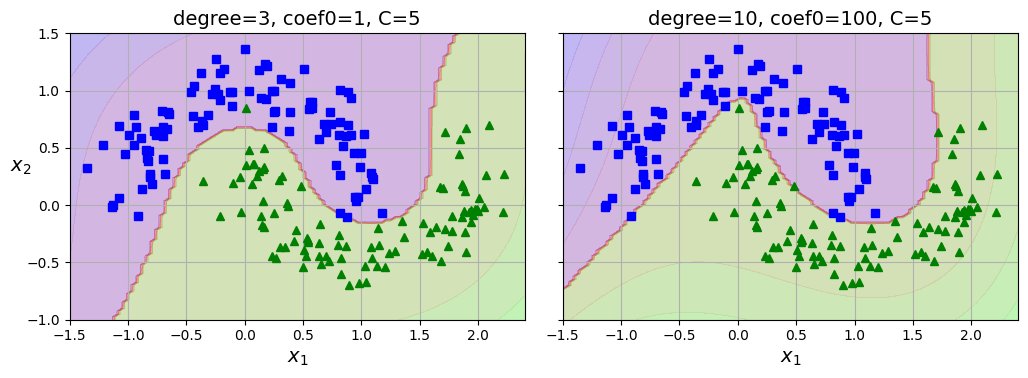

In [30]:
# extra code – this cell generates and saves Figure 5–7

poly100_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="poly", degree=10, coef0=100, C=5)
)
poly100_kernel_svm_clf.fit(X, y)

fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title("degree=3, coef0=1, C=5")

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title("degree=10, coef0=100, C=5")
plt.ylabel("")

save_fig("moons_kernelized_polynomial_svc_plot")
plt.show()

## Similarity Features

Another technique to tackle nonlinear problems is to add features computed using a
similarity function, which measures how much each instance resembles a particular
landmark, as we did in Chapter 2 when we added the geographic similarity features.
For example, let’s take the 1D dataset from earlier and add two landmarks to it at x1 =
–2 and x1 = 1 (see the left plot in Figure 5-8). Next, we’ll define the similarity function
to be the Gaussian RBF with γ = 0.3. This is a bell-shaped function varying from 0
(very far away from the landmark) to 1 (at the landmark).

Now we are ready to compute the new features. For example, let’s look at the instance
x1 = –1: it is located at a distance of 1 from the first landmark and 2 from the second
landmark. Therefore, its new features are x2 = exp(–0.3 × 12) ≈ 0.74 and x3 = exp(–0.3
× 22) ≈ 0.30. The plot on the right in Figure 5-8 shows the transformed dataset
(dropping the original features). As you can see, it is now linearly separable.

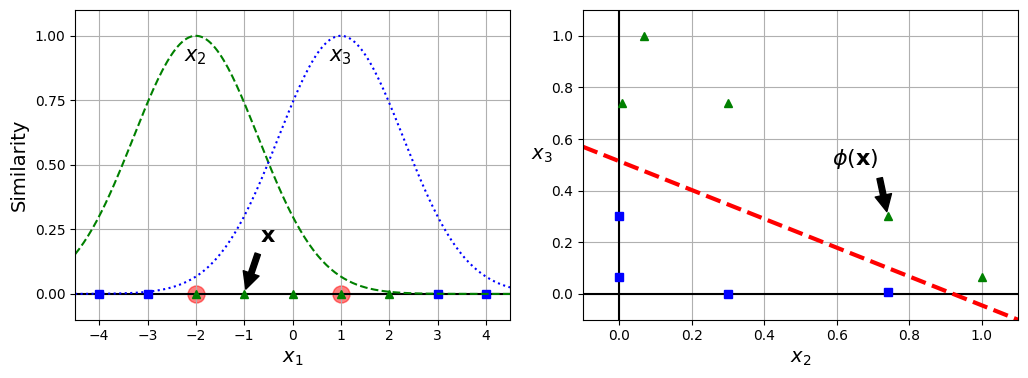

In [31]:
# extra code – this cell generates and saves Figure 5–8

def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10.5, 4))

plt.subplot(121)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel("$x_1$")
plt.ylabel("Similarity")
plt.annotate(
    r'$\mathbf{x}$',
    xy=(X1D[3, 0], 0),
    xytext=(-0.5, 0.20),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
    fontsize=16,
)
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=15)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=15)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel("$x_2$")
plt.ylabel("$x_3$  ", rotation=0)
plt.annotate(
    r'$\phi\left(\mathbf{x}\right)$',
    xy=(XK[3, 0], XK[3, 1]),
    xytext=(0.65, 0.50),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
    fontsize=16,
)
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

save_fig("kernel_method_plot")
plt.show()

You may wonder how to select the landmarks. The simplest approach is to create a
landmark at the location of each and every instance in the dataset. Doing that creates
many dimensions and thus increases the chances that the transformed training set
will be linearly separable. The downside is that a training set with m instances and
n features gets transformed into a training set with m instances and m features
(assuming you drop the original features). If your training set is very large, you end
up with an equally large number of features.

## Gaussian RBF Kernel

Just like the polynomial features method, the similarity features method can be useful
with any machine learning algorithm, but it may be computationally expensive to
compute all the additional features (especially on large training sets). Once again the
kernel trick does its SVM magic, making it possible to obtain a similar result as if you had added many similarity features, but without actually doing so. Let’s try the SVC
class with the Gaussian RBF kernel:

In [32]:
rbf_kernel_svm_clf = make_pipeline(StandardScaler(),
                                   SVC(kernel="rbf", gamma=5, C=0.001))
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=0.001, gamma=5))])

This model is represented at the bottom left in Figure 5-9. The other plots show
models trained with different values of hyperparameters gamma (γ) and C. Increasing
gamma makes the bell-shaped curve narrower (see the lefthand plots in Figure 5-8).
As a result, each instance’s range of influence is smaller: the decision boundary ends
up being more irregular, wiggling around individual instances. Conversely, a small
gamma value makes the bell-shaped curve wider: instances have a larger range of influ‐
ence, and the decision boundary ends up smoother. So γ acts like a regularization
hyperparameter: if your model is overfitting, you should reduce γ; if it is underfitting,
you should increase γ (similar to the C hyperparameter).

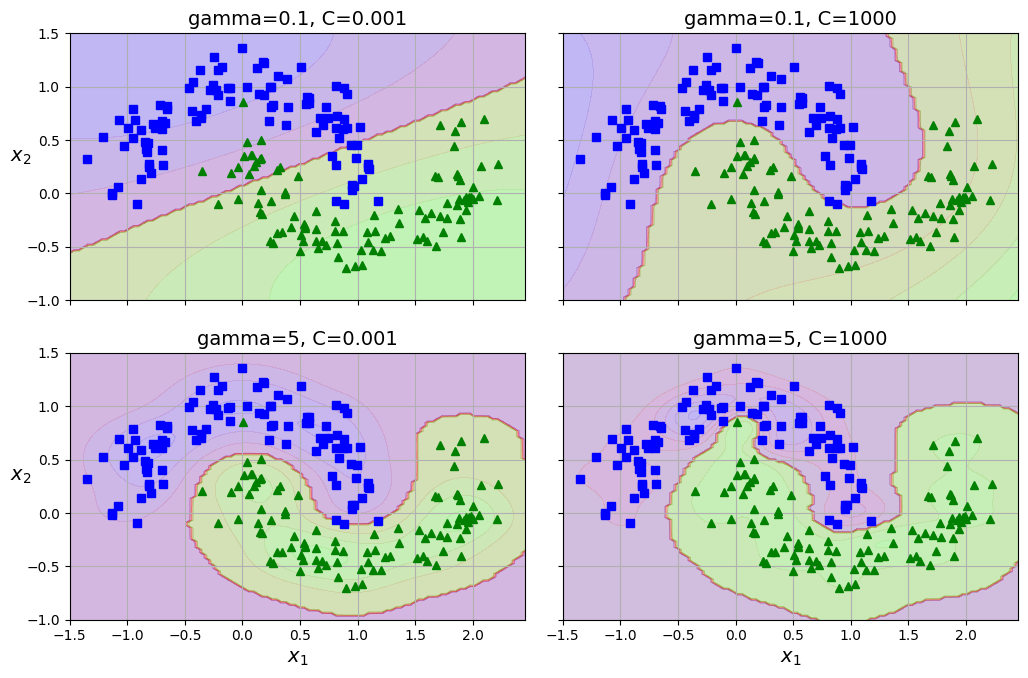

In [33]:
# extra code – this cell generates and saves Figure 5–9

from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = make_pipeline(
        StandardScaler(),
        SVC(kernel="rbf", gamma=gamma, C=C)
    )
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(f"gamma={gamma}, C={C}")
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

save_fig("moons_rbf_svc_plot")
plt.show()

# SVM Regression

To use SVMs for regression instead of classification, the trick is to tweak the objec‐
tive: instead of trying to fit the largest possible street between two classes while
limiting margin violations, SVM regression tries to fit as many instances as possible
on the street while limiting margin violations (i.e., instances off the street). The width
of the street is controlled by a hyperparameter, ϵ. Figure 5-10 shows two linear SVM
regression models trained on some linear data, one with a small margin (ϵ = 0.5) and
the other with a larger margin (ϵ = 1.2).

In [34]:
from sklearn.svm import LinearSVR

# extra code – these 3 lines generate a simple linear dataset
np.random.seed(42)
X = 2 * np.random.rand(50, 1)
y = 4 + 3 * X[:, 0] + np.random.randn(50)

svm_reg = make_pipeline(StandardScaler(),
                        LinearSVR(epsilon=0.5, dual=True, random_state=42))
svm_reg.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr',
                 LinearSVR(dual=True, epsilon=0.5, random_state=42))])

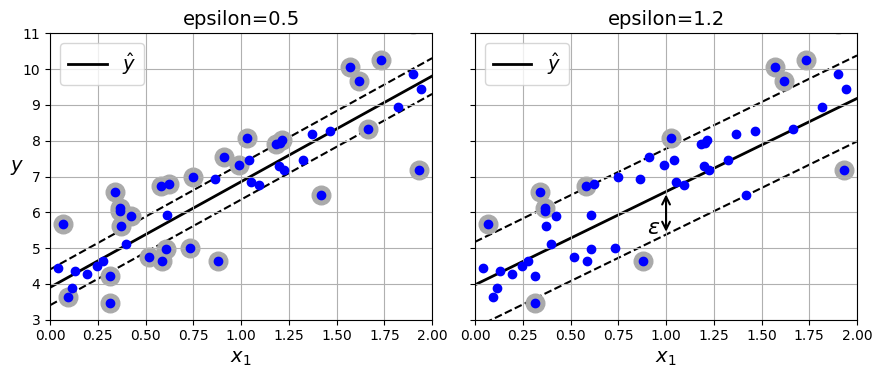

In [35]:
# extra code – this cell generates and saves Figure 5–10

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    epsilon = svm_reg[-1].epsilon
    off_margin = np.abs(y - y_pred) >= epsilon
    return np.argwhere(off_margin)

def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    epsilon = svm_reg[-1].epsilon
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$", zorder=-2)
    plt.plot(x1s, y_pred + epsilon, "k--", zorder=-2)
    plt.plot(x1s, y_pred - epsilon, "k--", zorder=-2)
    plt.scatter(X[svm_reg._support], y[svm_reg._support], s=180,
                facecolors='#AAA', zorder=-1)
    plt.plot(X, y, "bo")
    plt.xlabel("$x_1$")
    plt.legend(loc="upper left")
    plt.axis(axes)

svm_reg2 = make_pipeline(StandardScaler(),
                         LinearSVR(epsilon=1.2, dual=True, random_state=42))
svm_reg2.fit(X, y)

svm_reg._support = find_support_vectors(svm_reg, X, y)
svm_reg2._support = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg2.predict([[eps_x1]])

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg, X, y, [0, 2, 3, 11])
plt.title(f"epsilon={svm_reg[-1].epsilon}")
plt.ylabel("$y$", rotation=0)
plt.grid()
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(f"epsilon={svm_reg2[-1].epsilon}")
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg2[-1].epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.90, 5.4, r"$\epsilon$", fontsize=16)
plt.grid()
save_fig("svm_regression_plot")
plt.show()

Reducing ϵ increases the number of support vectors, which regularizes the model.
Moreover, if you add more training instances within the margin, it will not affect the
model’s predictions; thus, the model is said to be ϵ-insensitive.

To tackle nonlinear regression tasks, you can use a kernelized SVM model. Fig‐
ure 5-11 shows SVM regression on a random quadratic training set, using a second-
degree polynomial kernel. There is some regularization in the left plot (i.e., a small C
value), and much less in the right plot (i.e., a large C value).

In [36]:
from sklearn.svm import SVR

# extra code – these 3 lines generate a simple quadratic dataset
np.random.seed(42)
X = 2 * np.random.rand(50, 1) - 1
y = 0.2 + 0.1 * X[:, 0] + 0.5 * X[:, 0] ** 2 + np.random.randn(50) / 10

svm_poly_reg = make_pipeline(StandardScaler(),
                             SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1))
svm_poly_reg.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=0.01, degree=2, kernel='poly'))])

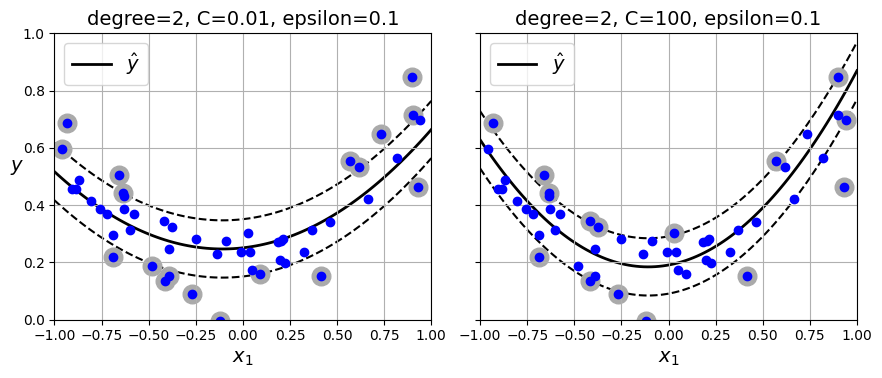

In [37]:
# extra code – this cell generates and saves Figure 5–11

svm_poly_reg2 = make_pipeline(StandardScaler(),
                             SVR(kernel="poly", degree=2, C=100))
svm_poly_reg2.fit(X, y)

svm_poly_reg._support = find_support_vectors(svm_poly_reg, X, y)
svm_poly_reg2._support = find_support_vectors(svm_poly_reg2, X, y)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg, X, y, [-1, 1, 0, 1])
plt.title(f"degree={svm_poly_reg[-1].degree}, "
          f"C={svm_poly_reg[-1].C}, "
          f"epsilon={svm_poly_reg[-1].epsilon}")
plt.ylabel("$y$", rotation=0)
plt.grid()

plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(f"degree={svm_poly_reg2[-1].degree}, "
          f"C={svm_poly_reg2[-1].C}, "
          f"epsilon={svm_poly_reg2[-1].epsilon}")
plt.grid()
save_fig("svm_with_polynomial_kernel_plot")
plt.show()

The SVR class is the regression equivalent of the SVC class, and the LinearSVR class is
the regression equivalent of the LinearSVC class. The LinearSVR class scales linearly
with the size of the training set (just like the LinearSVC class), while the SVR class gets
much too slow when the training set grows very large (just like the SVC class).

# Under the hood

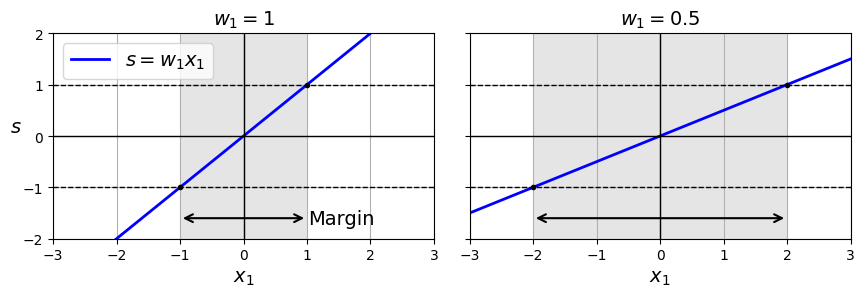

In [38]:
# extra code – this cell generates and saves Figure 5–12

import matplotlib.patches as patches

def plot_2D_decision_function(w, b, ylabel=True, x1_lim=[-3, 3]):
    x1 = np.linspace(x1_lim[0], x1_lim[1], 200)
    y = w * x1 + b
    half_margin = 1 / w

    plt.plot(x1, y, "b-", linewidth=2, label=r"$s = w_1 x_1$")
    plt.axhline(y=0, color='k', linewidth=1)
    plt.axvline(x=0, color='k', linewidth=1)
    rect = patches.Rectangle((-half_margin, -2), 2 * half_margin, 4,
                             edgecolor='none', facecolor='gray', alpha=0.2)
    plt.gca().add_patch(rect)
    plt.plot([-3, 3], [1, 1], "k--", linewidth=1)
    plt.plot([-3, 3], [-1, -1], "k--", linewidth=1)
    plt.plot(half_margin, 1, "k.")
    plt.plot(-half_margin, -1, "k.")
    plt.axis(x1_lim + [-2, 2])
    plt.xlabel("$x_1$")
    if ylabel:
        plt.ylabel("$s$", rotation=0, labelpad=5)
        plt.legend()
        plt.text(1.02, -1.6, "Margin", ha="left", va="center", color="k")

    plt.annotate(
        '', xy=(-half_margin, -1.6), xytext=(half_margin, -1.6),
        arrowprops={'ec': 'k', 'arrowstyle': '<->', 'linewidth': 1.5}
    )
    plt.title(f"$w_1 = {w}$")

fig, axes = plt.subplots(ncols=2, figsize=(9, 3.2), sharey=True)
plt.sca(axes[0])
plot_2D_decision_function(1, 0)
plt.grid()
plt.sca(axes[1])
plot_2D_decision_function(0.5, 0, ylabel=False)
plt.grid()
save_fig("small_w_large_margin_plot")
plt.show()

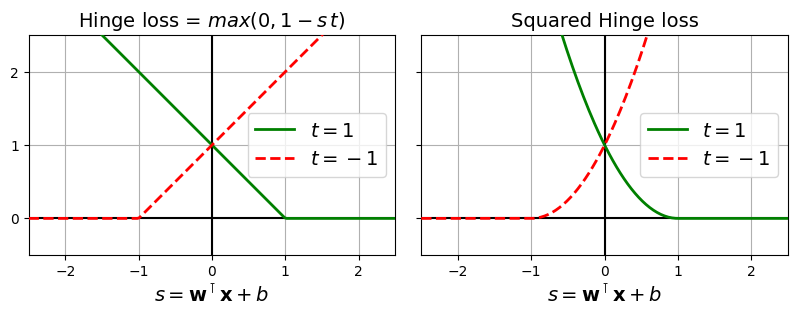

In [39]:
# extra code – this cell generates and saves Figure 5–13

s = np.linspace(-2.5, 2.5, 200)
hinge_pos = np.where(1 - s < 0, 0, 1 - s)  # max(0, 1 - s)
hinge_neg = np.where(1 + s < 0, 0, 1 + s)  # max(0, 1 + s)

titles = (r"Hinge loss = $max(0, 1 - s\,t)$", "Squared Hinge loss")

fix, axs = plt.subplots(1, 2, sharey=True, figsize=(8.2, 3))

for ax, loss_pos, loss_neg, title in zip(
        axs, (hinge_pos, hinge_pos ** 2), (hinge_neg, hinge_neg ** 2), titles):
    ax.plot(s, loss_pos, "g-", linewidth=2, zorder=10, label="$t=1$")
    ax.plot(s, loss_neg, "r--", linewidth=2, zorder=10, label="$t=-1$")
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.set_xlabel(r"$s = \mathbf{w}^\intercal \mathbf{x} + b$")
    ax.axis([-2.5, 2.5, -0.5, 2.5])
    ax.legend(loc="center right")
    ax.set_title(title)
    ax.set_yticks(np.arange(0, 2.5, 1))
    ax.set_aspect("equal")

save_fig("hinge_plot")
plt.show()

# Extra Material

## Linear SVM classifier implementation using Batch Gradient Descent

In [40]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 2)

In [41]:
from sklearn.base import BaseEstimator

class MyLinearSVC(BaseEstimator):
    def __init__(self, C=1, eta0=1, eta_d=10000, n_epochs=1000,
                 random_state=None):
        self.C = C
        self.eta0 = eta0
        self.n_epochs = n_epochs
        self.random_state = random_state
        self.eta_d = eta_d

    def eta(self, epoch):
        return self.eta0 / (epoch + self.eta_d)
        
    def fit(self, X, y):
        # Random initialization
        if self.random_state:
            np.random.seed(self.random_state)
        w = np.random.randn(X.shape[1], 1)  # n feature weights
        b = 0

        t = np.array(y, dtype=np.float64).reshape(-1, 1) * 2 - 1
        X_t = X * t
        self.Js = []

        # Training
        for epoch in range(self.n_epochs):
            support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
            X_t_sv = X_t[support_vectors_idx]
            t_sv = t[support_vectors_idx]

            J = 1/2 * (w * w).sum() + self.C * ((1 - X_t_sv.dot(w)).sum() - b * t_sv.sum())
            self.Js.append(J)

            w_gradient_vector = w - self.C * X_t_sv.sum(axis=0).reshape(-1, 1)
            b_derivative = -self.C * t_sv.sum()
                
            w = w - self.eta(epoch) * w_gradient_vector
            b = b - self.eta(epoch) * b_derivative
            

        self.intercept_ = np.array([b])
        self.coef_ = np.array([w])
        support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
        self.support_vectors_ = X[support_vectors_idx]
        return self

    def decision_function(self, X):
        return X.dot(self.coef_[0]) + self.intercept_[0]

    def predict(self, X):
        return self.decision_function(X) >= 0

In [42]:
C = 2
svm_clf = MyLinearSVC(C=C, eta0 = 10, eta_d = 1000, n_epochs=60000,
                      random_state=2)
svm_clf.fit(X, y)
svm_clf.predict(np.array([[5, 2], [4, 1]]))

array([[ True],
       [False]])

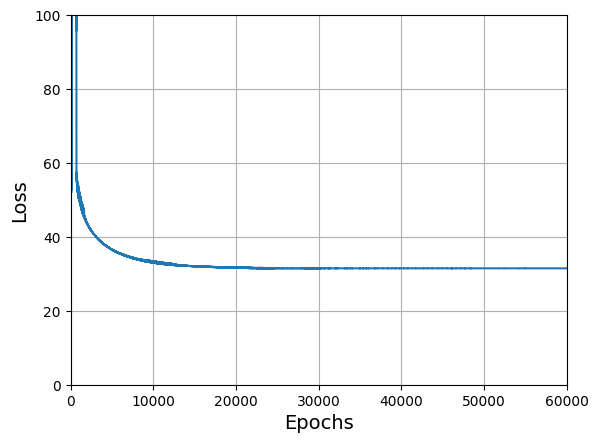

In [43]:
plt.plot(range(svm_clf.n_epochs), svm_clf.Js)
plt.axis([0, svm_clf.n_epochs, 0, 100])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [44]:
print(svm_clf.intercept_, svm_clf.coef_)

[-15.56761653] [[[2.28120287]
  [2.71621742]]]


In [45]:
svm_clf2 = SVC(kernel="linear", C=C)
svm_clf2.fit(X, y.ravel())
print(svm_clf2.intercept_, svm_clf2.coef_)

[-15.51721253] [[2.27128546 2.71287145]]


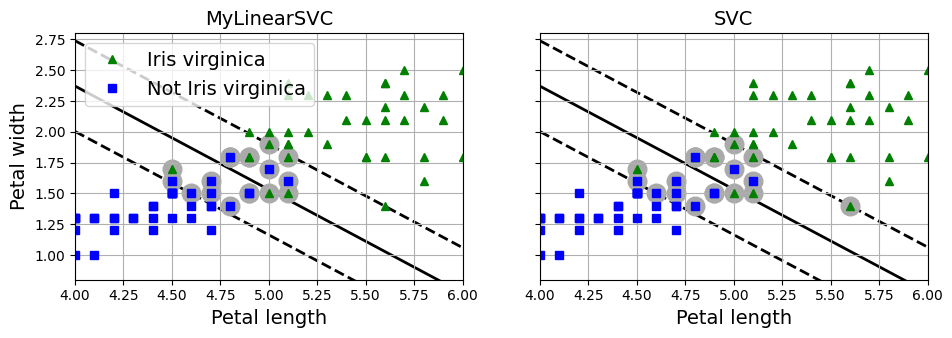

In [46]:
yr = y.ravel()
fig, axes = plt.subplots(ncols=2, figsize=(11, 3.2), sharey=True)
plt.sca(axes[0])
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs", label="Not Iris virginica")
plot_svc_decision_boundary(svm_clf, 4, 6)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.title("MyLinearSVC")
plt.axis([4, 6, 0.8, 2.8])
plt.legend(loc="upper left")
plt.grid()

plt.sca(axes[1])
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("Petal length")
plt.title("SVC")
plt.axis([4, 6, 0.8, 2.8])
plt.grid()

plt.show()

[-12.52988101   1.94162342   1.84544824]


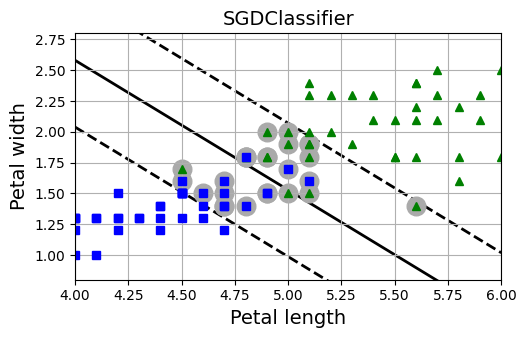

In [47]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="hinge", alpha=0.017, max_iter=1000, tol=1e-3,
                        random_state=42)
sgd_clf.fit(X, y)

m = len(X)
t = np.array(y).reshape(-1, 1) * 2 - 1  # -1 if y == 0, or +1 if y == 1
X_b = np.c_[np.ones((m, 1)), X]  # Add bias input x0=1
X_b_t = X_b * t
sgd_theta = np.r_[sgd_clf.intercept_[0], sgd_clf.coef_[0]]
print(sgd_theta)
support_vectors_idx = (X_b_t.dot(sgd_theta) < 1).ravel()
sgd_clf.support_vectors_ = X[support_vectors_idx]
sgd_clf.C = C

plt.figure(figsize=(5.5, 3.2))
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(sgd_clf, 4, 6)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.title("SGDClassifier")
plt.axis([4, 6, 0.8, 2.8])
plt.grid()

plt.show()

# Exercise solutions

## 1. to 8.

1. The fundamental idea behind Support Vector Machines is to fit the widest possible "street" between the classes. In other words, the goal is to have the largest possible margin between the decision boundary that separates the two classes and the training instances. When performing soft margin classification, the SVM searches for a compromise between perfectly separating the two classes and having the widest possible street (i.e., a few instances may end up on the street). Another key idea is to use kernels when training on nonlinear datasets. SVMs can also be tweaked to perform linear and nonlinear regression, as well as novelty detection.
2. After training an SVM, a _support vector_ is any instance located on the "street" (see the previous answer), including its border. The decision boundary is entirely determined by the support vectors. Any instance that is _not_ a support vector (i.e., is off the street) has no influence whatsoever; you could remove them, add more instances, or move them around, and as long as they stay off the street they won't affect the decision boundary. Computing the predictions with a kernelized SVM only involves the support vectors, not the whole training set.
3. SVMs try to fit the largest possible "street" between the classes (see the first answer), so if the training set is not scaled, the SVM will tend to neglect small features (see Figure 5–2).
4. You can use the `decision_function()` method to get confidence scores. These scores represent the distance between the instance and the decision boundary. However, they cannot be directly converted into an estimation of the class probability. If you set `probability=True` when creating an `SVC`, then at the end of training it will use 5-fold cross-validation to generate out-of-sample scores for the training samples, and it will train a `LogisticRegression` model to map these scores to estimated probabilities. The `predict_proba()` and `predict_log_proba()` methods will then be available.
5. All three classes can be used for large-margin linear classification. The `SVC` class also supports the kernel trick, which makes it capable of handling nonlinear tasks. However, this comes at a cost: the `SVC` class does not scale well to datasets with many instances. It does scale well to a large number of features, though. The `LinearSVC` class implements an optimized algorithm for linear SVMs, while `SGDClassifier` uses Stochastic Gradient Descent. Depending on the dataset `LinearSVC` may be a bit faster than `SGDClassifier`, but not always, and `SGDClassifier` is more flexible, plus it supports incremental learning.
6. If an SVM classifier trained with an RBF kernel underfits the training set, there might be too much regularization. To decrease it, you need to increase `gamma` or `C` (or both).
7. A Regression SVM model tries to fit as many instances within a small margin around its predictions. If you add instances within this margin, the model will not be affected at all: it is said to be _ϵ-insensitive_.
8. The kernel trick is mathematical technique that makes it possible to train a nonlinear SVM model. The resulting model is equivalent to mapping the inputs to another space using a nonlinear transformation, then training a linear SVM on the resulting high-dimensional inputs. The kernel trick gives the same result without having to transform the inputs at all.

# 9.

_Exercise: Train a `LinearSVC` on a linearly separable dataset. Then train an `SVC` and a `SGDClassifier` on the same dataset. See if you can get them to produce roughly the same model._

Let's use the Iris dataset: the Iris Setosa and Iris Versicolor classes are linearly separable.

In [34]:
from sklearn import datasets

iris = datasets.load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

Now let's build and train 3 models:
* Remember that `LinearSVC` uses `loss="squared_hinge"` by default, so if we want all 3 models to produce similar results, we need to set `loss="hinge"`.
* Also, the `SVC` class uses an RBF kernel by default, so we need to set `kernel="linear"` to get similar results as the other two models.
* Lastly, the `SGDClassifier` class does not have a `C` hyperparameter, but it has another regularization hyperparameter called `alpha`, so we can tweak it to get similar results as the other two models.

In [35]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

C = 5
alpha = 0.05

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lin_clf = LinearSVC(loss="hinge", C=C, dual=True, random_state=42).fit(X_scaled, y)
svc_clf = SVC(kernel="linear", C=C).fit(X_scaled, y)
sgd_clf = SGDClassifier(alpha=alpha, random_state=42).fit(X_scaled, y)

Let's plot the decision boundaries of these three models:

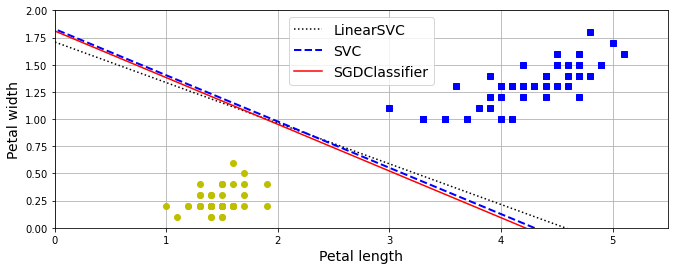

In [36]:
def compute_decision_boundary(model):
    w = -model.coef_[0, 0] / model.coef_[0, 1]
    b = -model.intercept_[0] / model.coef_[0, 1]
    return scaler.inverse_transform([[-10, -10 * w + b], [10, 10 * w + b]])

lin_line = compute_decision_boundary(lin_clf)
svc_line = compute_decision_boundary(svc_clf)
sgd_line = compute_decision_boundary(sgd_clf)

# Plot all three decision boundaries
plt.figure(figsize=(11, 4))
plt.plot(lin_line[:, 0], lin_line[:, 1], "k:", label="LinearSVC")
plt.plot(svc_line[:, 0], svc_line[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(sgd_line[:, 0], sgd_line[:, 1], "r-", label="SGDClassifier")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs") # label="Iris versicolor"
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo") # label="Iris setosa"
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper center")
plt.axis([0, 5.5, 0, 2])
plt.grid()

plt.show()

Close enough!

# 10.

_Exercise: Train an SVM classifier on the Wine dataset, which you can load using `sklearn.datasets.load_wine()`. This dataset contains the chemical analysis of 178 wine samples produced by 3 different cultivators: the goal is to train a classification model capable of predicting the cultivator based on the wine's chemical analysis. Since SVM classifiers are binary classifiers, you will need to use one-versus-all to classify all 3 classes. What accuracy can you reach?_

First, let's fetch the dataset, look at its description, then split it into a training set and a test set:

In [37]:
from sklearn.datasets import load_wine

wine = load_wine(as_frame=True)

In [38]:
print(wine.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
<<26 more lines>>
wine.

Original Owners: 

Forina, M. et al, PARVUS - 
An Extendible Package for Data Exploration, Classification and Correlation. 
Inst

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data, wine.target, random_state=42)

In [40]:
X_train.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
100,12.08,2.08,1.70,17.5,97.0,2.23,2.17,0.26,1.40,3.30,1.27,2.96,710.0
122,12.42,4.43,2.73,26.5,102.0,2.20,2.13,0.43,1.71,2.08,0.92,3.12,365.0
154,12.58,1.29,2.10,20.0,103.0,1.48,0.58,0.53,1.40,7.60,0.58,1.55,640.0
51,13.83,1.65,2.60,17.2,94.0,2.45,2.99,0.22,2.29,5.60,1.24,3.37,1265.0


In [41]:
y_train.head()

2      0
100    1
122    1
154    2
51     0
Name: target, dtype: int64

Let's start simple, with a linear SVM classifier. It will automatically use the One-vs-All (also called One-vs-the-Rest, OvR) strategy, so there's nothing special we need to do to handle multiple classes. Easy, right?

In [42]:
lin_clf = LinearSVC(dual=True, random_state=42)
lin_clf.fit(X_train, y_train)

/Users/ageron/miniconda3/envs/homl3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(random_state=42)

Oh no! It failed to converge. Can you guess why? Do you think we must just increase the number of training iterations? Let's see:

In [43]:
lin_clf = LinearSVC(max_iter=1_000_000, dual=True, random_state=42)
lin_clf.fit(X_train, y_train)

/Users/ageron/miniconda3/envs/homl3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(max_iter=1000000, random_state=42)

Even with one million iterations, it still did not converge. There must be another problem.

Let's still evaluate this model with `cross_val_score`, it will serve as a baseline:

In [44]:
from sklearn.model_selection import cross_val_score

cross_val_score(lin_clf, X_train, y_train).mean()

/Users/ageron/miniconda3/envs/homl3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ageron/miniconda3/envs/homl3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ageron/miniconda3/envs/homl3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ageron/miniconda3/envs/homl3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ageron/miniconda3/envs/homl3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.90997150997151

Well 91% accuracy on this dataset is not great. So did you guess what the problem is?

That's right, we forgot to scale the features! Always remember to scale the features when using SVMs:

In [45]:
lin_clf = make_pipeline(StandardScaler(),
                        LinearSVC(dual=True, random_state=42))
lin_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=42))])

Now it converges without any problem. Let's measure its performance:

In [46]:
from sklearn.model_selection import cross_val_score

cross_val_score(lin_clf, X_train, y_train).mean()

0.9774928774928775

Nice! We get 97.7% accuracy, that's much better.

Let's see if a kernelized SVM will do better. We will use a default `SVC` for now:

In [47]:
svm_clf = make_pipeline(StandardScaler(), SVC(random_state=42))
cross_val_score(svm_clf, X_train, y_train).mean()

0.9698005698005698

That's not better, but perhaps we need to do a bit of hyperparameter tuning:

In [48]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform

param_distrib = {
    "svc__gamma": loguniform(0.001, 0.1),
    "svc__C": uniform(1, 10)
}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distrib, n_iter=100, cv=5,
                                   random_state=42)
rnd_search_cv.fit(X_train, y_train)
rnd_search_cv.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=9.925589984899778, gamma=0.011986281799901176,
                     random_state=42))])

In [49]:
rnd_search_cv.best_score_

0.9925925925925926

Ah, this looks excellent! Let's select this model. Now we can test it on the test set:

In [50]:
rnd_search_cv.score(X_test, y_test)

0.9777777777777777

This tuned kernelized SVM performs better than the `LinearSVC` model, but we get a lower score on the test set than we measured using cross-validation. This is quite common: since we did so much hyperparameter tuning, we ended up slightly overfitting the cross-validation test sets. It's tempting to tweak the hyperparameters a bit more until we get a better result on the test set, but this would probably not help, as we would just start overfitting the test set. Anyway, this score is not bad at all, so let's stop here.

## 11.

_Exercise: Train and fine-tune an SVM regressor on the California housing dataset. You can use the original dataset rather than the tweaked version we used in Chapter 2. The original dataset can be fetched using `sklearn.datasets.fetch_california_housing()`. The targets represent hundreds of thousands of dollars. Since there are over 20,000 instances, SVMs can be slow, so for hyperparameter tuning you should use much less instances (e.g., 2,000), to test many more hyperparameter combinations. What is your best model's RMSE?_

Let's load the dataset:

In [51]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X = housing.data
y = housing.target

Split it into a training set and a test set:

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

Don't forget to scale the data!

Let's train a simple `LinearSVR` first:

In [53]:
from sklearn.svm import LinearSVR

lin_svr = make_pipeline(StandardScaler(), LinearSVR(dual=True, random_state=42))
lin_svr.fit(X_train, y_train)

/Users/ageron/miniconda3/envs/homl3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(random_state=42))])

It did not converge, so let's increase `max_iter`:

In [54]:
lin_svr = make_pipeline(StandardScaler(),
                        LinearSVR(max_iter=5000, dual=True, random_state=42))
lin_svr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(max_iter=5000, random_state=42))])

Let's see how it performs on the training set:

In [55]:
from sklearn.metrics import mean_squared_error

y_pred = lin_svr.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
mse

0.9595484665813285

Let's look at the RMSE:

In [56]:
np.sqrt(mse)

0.979565447829459

In this dataset, the targets represent hundreds of thousands of dollars. The RMSE gives a rough idea of the kind of error you should expect (with a higher weight for large errors): so with this model we can expect errors close to $98,000! Not great. Let's see if we can do better with an RBF Kernel. We will use randomized search with cross validation to find the appropriate hyperparameter values for `C` and `gamma`:

In [57]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform

svm_clf = make_pipeline(StandardScaler(), SVR())

param_distrib = {
    "svr__gamma": loguniform(0.001, 0.1),
    "svr__C": uniform(1, 10)
}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distrib,
                                   n_iter=100, cv=3, random_state=42)
rnd_search_cv.fit(X_train[:2000], y_train[:2000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('svr', SVR())]),
                   n_iter=100,
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff030704ee0>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff030704fd0>},
                   random_state=42)

In [58]:
rnd_search_cv.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=4.63629602379294, gamma=0.08781408196485974))])

In [59]:
-cross_val_score(rnd_search_cv.best_estimator_, X_train, y_train,
                 scoring="neg_root_mean_squared_error")

array([0.58835648, 0.57468589, 0.58085278, 0.57109886, 0.59853029])

Looks much better than the linear model. Let's select this model and evaluate it on the test set:

In [60]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse

0.5854732265172222

So SVMs worked very well on the Wine dataset, but not so much on the California Housing dataset. In Chapter 2, we found that Random Forests worked better for that dataset.

And that's all for today!